# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

    """
    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    """

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [65]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import utils.cliffwalking_test as check_test
from utils.plot_utils import plot_values_cliffwalking

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [66]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [67]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

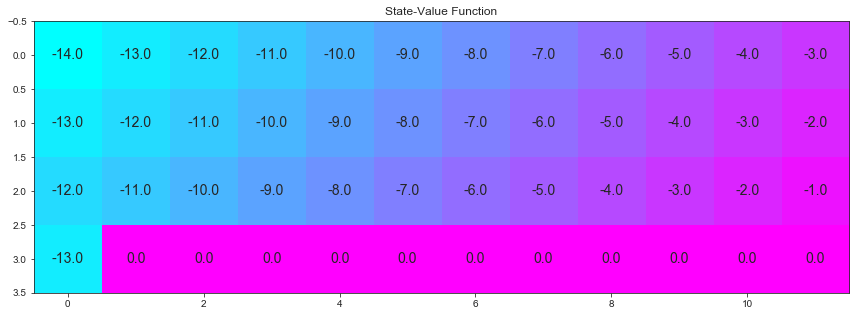

In [68]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values_cliffwalking(V_opt)

# Helpers


In [199]:
# Generate policy based on epsilon
def get_epsilon_greedy_policy(Q_state, epsilon, num_action, eps_const=None):
    # If we want to set const eps
    if eps_const:
        epsilon = eps_const
    
    #initialize policy as all ones
    epsilon_greedy_policy = np.ones(num_action)
    
    # multiply all actions of probability to (epsilon / num_action)
    epsilon_greedy_policy = epsilon_greedy_policy * (epsilon / num_action)
    
    # Use Q-table, find the greedy action for state-action
    greedy_action_index = np.argmax(Q_state) # (max probability in policy)
    
    # Change greedy action's probability
    epsilon_greedy_policy[greedy_action_index] = 1 - epsilon + (epsilon / num_action)
    
    return epsilon_greedy_policy

# Update Q table after for a given step
def update_Q_table_sarsa(next_return, prev_return, reward, alpha, gamma):
    # Update Step, Q(S, A) = Q(S,A) +  α * (R + Sarsa_Method() - Q(S,A))
    return prev_return + (alpha * (reward + (gamma * next_return) - prev_return))

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [224]:
def complete_sarsa_episode(env, Q, epsilon, alpha, gamma, n_steps=300):
    
    # begin an episode, observe S        
    score = 0
    state = env.reset() # State is just int [0...47]

    # Epsilon-greedy policy
    prob = get_epsilon_greedy_policy(Q[state], epsilon, env.nA) # prob of selecting ea action
    
    # Choose action
    action = np.random.choice(np.arange(env.nA), p=prob)
    
    t_steps = np.arange(n_steps)
    prev_action = action
    prev_state = state
    
    # Continue for t_steps:
    for t_step in t_steps:
        
        # Take a step and update score
        next_state, reward, done, info = env.step(prev_action)
        score += reward

        # Not final time step
        if not done:
            prob = get_epsilon_greedy_policy(Q[next_state], epsilon, env.nA)
            next_action = np.random.choice(np.arange(env.nA), p=prob)
            
            next_return = Q[next_state][next_action]
            prev_return = Q[prev_state][prev_action]
            
            Q[prev_state][prev_action] = update_Q_table_sarsa(next_return, prev_return, reward, alpha, gamma)

            prev_action = next_action
            prev_state = next_state
        
        if done:
            prev_return = Q[prev_state][prev_action]
            Q[prev_state][prev_action] = update_Q_table_sarsa(0, prev_return, reward, alpha, gamma)
            break
        
    return score, Q

def sarsa(env, num_episodes, alpha, gamma=1.0):
    np.seterr('raise')
    # initialize action-value function (empty dictionary of arrays)
    num_actions = env.nA
    Q = defaultdict(lambda: np.zeros(num_actions))
    
    # initialize performance monitor, as double ended queue
    plot_every = 100
    scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):

        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # Allow epsilon to be inversly proportionate to the episode count
        epsilon = 1.0 / i_episode
        
        # Complete an episode
        score, Q = complete_sarsa_episode(env, Q, epsilon, alpha, gamma)
        scores.append(score)
        
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

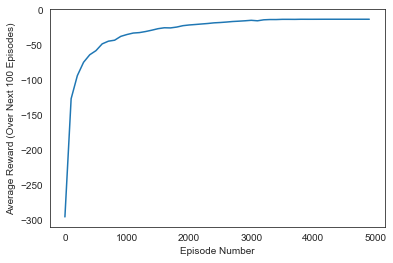

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  3  1  1  1  1  1  1  2  3  2  2]
 [ 3  2  0  1  3  1  2  0  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


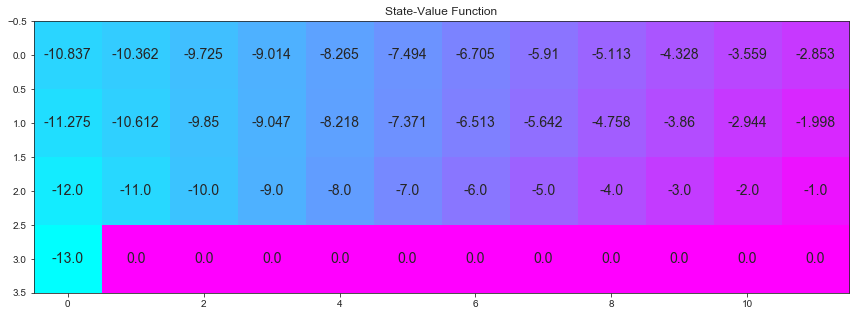

In [225]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values_cliffwalking(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [226]:
################################
#       SARSAMAX HELPERS      #
################################

def complete_sarsamax_episode(env, Q, epsilon, alpha, gamma, n_steps=300):
    
    # begin an episode, observe S        
    score = 0
    state = env.reset() # State is just int [0...47]

    # Epsilon-greedy policy
    prob = get_epsilon_greedy_policy(Q[state], epsilon, env.nA) # prob of selecting ea action
    
    # Choose action
    action = np.random.choice(np.arange(env.nA), p=prob)
    
    t_steps = np.arange(n_steps)
    prev_action = action
    prev_state = state
    
    # Continue for t_steps:
    for t_step in t_steps:
        
        # Take a step and update score
        next_state, reward, done, info = env.step(prev_action)
        score += reward

        # Not final time step
        if not done:
            
            next_action = np.argmax(Q[next_state])

            next_return = Q[next_state][next_action]
            prev_return = Q[prev_state][prev_action]
            
            Q[prev_state][prev_action] = update_Q_table_sarsa(next_return, prev_return, reward, alpha, gamma)

            prev_action = next_action
            prev_state = next_state
        
        if done:
            prev_return = Q[prev_state][prev_action]
            Q[prev_state][prev_action] = update_Q_table_sarsa(0, prev_return, reward, alpha, gamma)
            break
        
    return score, Q

In [227]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    np.seterr('raise')
    # initialize action-value function (empty dictionary of arrays)
    num_actions = env.nA
    Q = defaultdict(lambda: np.zeros(num_actions))
    
    # initialize performance monitor, as double ended queue
    plot_every = 100
    scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):

        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # Allow epsilon to be inversly proportionate to the episode count
        epsilon = 1.0 / i_episode
        
        # Complete an episode
        score, Q = complete_sarsamax_episode(env, Q, epsilon, alpha, gamma)
        scores.append(score)
        
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

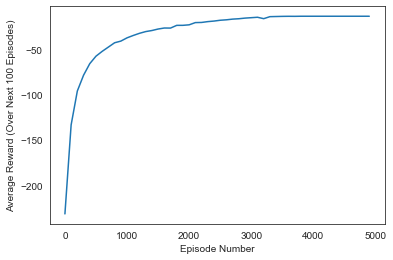

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  0  1  1  1  1  2  1  2  1  0]
 [ 2  1  1  1  1  3  1  1  2  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


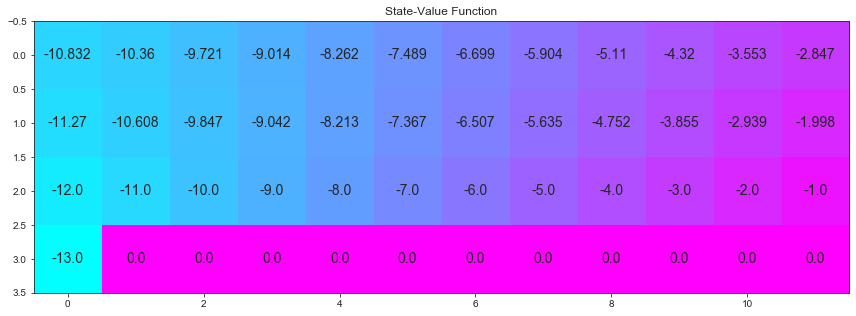

In [228]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values_cliffwalking([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [212]:
################################
#   EXPECTED SARSA HELPERS    #
################################

def complete_expected_sarsa_episode(env, Q, epsilon, alpha, gamma, n_steps=300):
    
    # begin an episode, observe S        
    score = 0
    state = env.reset() # State is just int [0...47]

    # Epsilon-greedy policy
    prob = get_epsilon_greedy_policy(Q[state], epsilon, env.nA) # prob of selecting ea action
    
    # Choose action
    action = np.random.choice(np.arange(env.nA), p=prob)
    
    t_steps = np.arange(n_steps)
    prev_action = action
    prev_state = state
    
    # Continue for t_steps:
    for t_step in t_steps:
        
        # Take a step and update score
        next_state, reward, done, info = env.step(prev_action)
        score += reward

        # Not final time step
        if not done:
            # We are defining a const, eps here.
            prob = get_epsilon_greedy_policy(Q[next_state], epsilon, env.nA, eps_const=0.005)
            next_action = np.random.choice(np.arange(env.nA), p=prob)
            
            # Dot Product of [action_prob dot expected_ret]
            next_return = np.dot(Q[next_state], prob)
            prev_return = Q[prev_state][prev_action]
            
            Q[prev_state][prev_action] = update_Q_table_sarsa(next_return, prev_return, reward, alpha, gamma)

            prev_action = next_action
            prev_state = next_state
        
        if done:
            prev_return = Q[prev_state][prev_action]
            Q[prev_state][prev_action] = update_Q_table_sarsa(0, prev_return, reward, alpha, gamma)
            break
        
        
    return score, Q

In [213]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    np.seterr('raise')
    # initialize action-value function (empty dictionary of arrays)
    num_actions = env.nA
    Q = defaultdict(lambda: np.zeros(num_actions))
    
    # initialize performance monitor, as double ended queue
    plot_every = 100
    scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):

        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # Allow epsilon to be inversly proportionate to the episode count
        epsilon = 1.0 / i_episode
        
        # Complete an episode
        score, Q = complete_expected_sarsa_episode(env, Q, epsilon, alpha, gamma)
        scores.append(score)
        
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

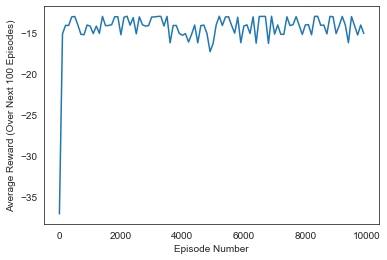

Best Average Reward over 100 Episodes:  -13.02


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  1  1  1  2  1  1  1  0  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


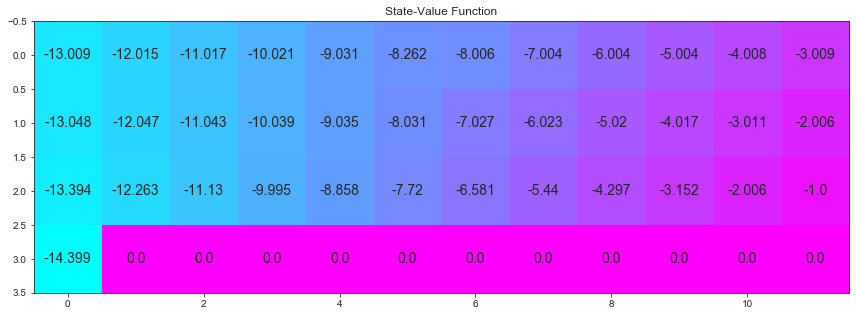

In [214]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values_cliffwalking([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

# Analyzing Performance

### Similarities

All of the TD control methods we have examined (Sarsa, Sarsamax, Expected Sarsa) converge to the optimal action-value function q* and yield the optimal policy π* 

1. the value of ϵ decays in accordance with the GLIE conditions, and 
2. the step-size parameter α is sufficiently small.

### Differences

The differences between these algorithms are summarized below:

- Sarsa and Expected Sarsa are both **on-policy** TD control algorithms. In this case, the same (ϵ-greedy) policy that is evaluated and improved is also used to select actions.
- Sarsamax is an **off-policy method**, where the (greedy) policy that is evaluated and improved is different from the (ϵ-greedy) policy that is used to select actions.
- On-policy TD control methods (like Expected Sarsa and Sarsa) have better online performance than off-policy TD control methods (like Sarsamax).
- Expected Sarsa generally achieves better performance than Sarsa.

![Cliff_walking](images/cliff_walking_analysis.png)

The figure shows the performance of Sarsa and Q-learning on the cliff walking environment for constant ϵ=0.1. As described in the textbook, in this case:

- Q-learning achieves worse online performance (where the agent collects less reward on average in each episode), but learns the optimal policy, and
- Sarsa achieves better online performance, but learns a sub-optimal "safe" policy.